# Определение возраста покупателей

# Введение


**План выполнения проекта:**

    В этом уроке проводим исследовательский анализ набора данных в Jupyter. Затем скачиваем тетрадь Jupyter Notebook.
    В 4-м уроке обучаем модель в GPU-тренажёре и сохраняем результат вывода модели на экран.
    В 5-м уроке объединяем в финальной тетради Jupyter Notebook исследовательский анализ данных, код и вывод модели. Затем анализируем результат обучения модели.

Метрика качества - MAE.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

Извлечь данные из папки поможет новый метод *ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...)*.

## Исследовательский анализ данных

Проведём исследовательский анализ данных:

    Посмотрим на размер выборки.
    Построим график распределения возраста в выборке.
    Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

In [1]:
# Импорты

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Найдено 7591 файлов, проверим:

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер выборки - 7591 объект, пропусков нет, типы данных корректны. Построим график распределения возрастов.

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


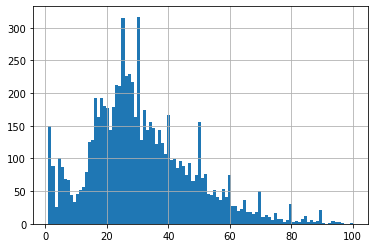

In [5]:
labels.real_age.hist(bins=100);

В датасете имеются изображения людей возрастов от 1 до 100. На графике видно, что пики приходятся на круглые значения или дробные 5, что может означать, что данные о возрасте не совсем корректные, а многие значения округлены.

Рассмотрим некоторые изображения:

In [6]:
features, target = next(train_gen_flow)

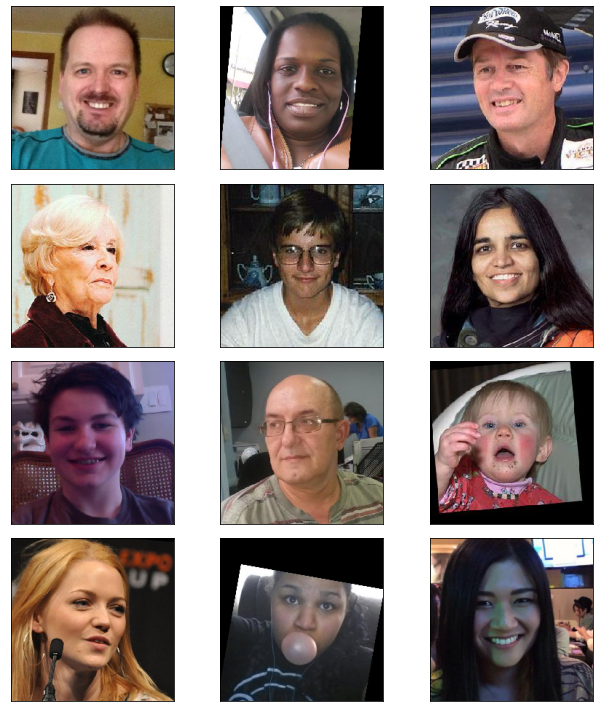

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Предварительный вывод**

Нам предоставлен датасет с 7591 изображением людей возрастов от 1 года до 100 лет с большим количеством округлений до 5.

По рассмотренным изображением можем предположить, что качество модели будет ниже, чем ожидается, так как качество лиц на фотографиях низкое: имеется большое количество предметов как на фоне, так и внутри овала лица (очки, микрофон, рука, аксессуары), некоторые лица обрезаны, либо не направлены "в камеру".

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=666)     
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=666)     
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),  weights='imagenet', include_top=False)
    optimizer = Adam(lr=0.0005)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

Результат вычислений:

```

Train for 356 steps, validate for 60 steps
Epoch 1/10
2022-10-04 11:12:07.938956: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-04 11:12:08.247204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 208.7856 - mae: 10.9630 - val_loss: 301.1389 - val_mae: 12.9054
Epoch 2/10
356/356 - 41s - loss: 135.8058 - mae: 8.9014 - val_loss: 287.5185 - val_mae: 12.6987
Epoch 3/10
356/356 - 41s - loss: 105.7673 - mae: 7.8340 - val_loss: 135.6026 - val_mae: 9.3348
Epoch 4/10
356/356 - 41s - loss: 94.1648 - mae: 7.4228 - val_loss: 110.5554 - val_mae: 7.7365
Epoch 5/10
356/356 - 41s - loss: 79.8790 - mae: 6.7931 - val_loss: 116.0851 - val_mae: 8.1397
Epoch 6/10
356/356 - 41s - loss: 67.3824 - mae: 6.2807 - val_loss: 117.7488 - val_mae: 8.6196
Epoch 7/10
356/356 - 42s - loss: 63.0984 - mae: 6.0766 - val_loss: 191.2763 - val_mae: 10.2611
Epoch 8/10
356/356 - 43s - loss: 50.8973 - mae: 5.4936 - val_loss: 111.6713 - val_mae: 8.1163
Epoch 9/10
356/356 - 44s - loss: 39.5217 - mae: 4.8209 - val_loss: 106.4893 - val_mae: 7.9405
Epoch 10/10
356/356 - 44s - loss: 35.5505 - mae: 4.5874 - val_loss: 92.7543 - val_mae: 7.1845
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 92.7543 - mae: 7.1845
Test MAE: 7.1845

```

Требуемое качество модели достигнуто, MAE на валидационной выборке - 7,18.

## Анализ обученной модели

Качества полученной модели достаточно для решения задачи, но с целью улучшения проверим характер изменения MAE по мере увеличения эпох.

Увеличение эпох с целью снижения МАЕ не привело к однозначному результату: значение ошибки колеблется от 6,64 до 8,42:

```
...
Epoch 12/20
356/356 - 44s - loss: 32.7959 - mae: 4.4097 - val_loss: 100.6064 - val_mae: 7.6904
Epoch 13/20
356/356 - 44s - loss: 28.0190 - mae: 4.0946 - val_loss: 96.6065 - val_mae: 7.4429
Epoch 14/20
356/356 - 44s - loss: 24.1664 - mae: 3.7813 - val_loss: 117.7981 - val_mae: 8.4168
Epoch 15/20
356/356 - 44s - loss: 25.3384 - mae: 3.9112 - val_loss: 101.2391 - val_mae: 7.6434
Epoch 16/20
356/356 - 44s - loss: 29.3779 - mae: 4.1713 - val_loss: 99.3392 - val_mae: 7.6770
Epoch 17/20
356/356 - 44s - loss: 22.0358 - mae: 3.6097 - val_loss: 79.8254 - val_mae: 6.6190
Epoch 18/20
356/356 - 45s - loss: 16.3766 - mae: 3.1402 - val_loss: 80.9581 - val_mae: 6.7009
Epoch 19/20
356/356 - 45s - loss: 15.5700 - mae: 3.0217 - val_loss: 76.0962 - val_mae: 6.6499
Epoch 20/20
356/356 - 45s - loss: 14.6217 - mae: 2.9487 - val_loss: 97.0179 - val_mae: 7.3287
...
60/60 - 10s - loss: 97.0179 - mae: 7.3287
Test MAE: 7.3287
```

# Вывод

Предполагаем, что наибольшую ошибку модель получает при анализе возраста наиболее взрослых людей на фотографии. Для детей ошибка 7 лет является недопустимой, тогда как для людей в возрасте старше 60 ошибка может достигать крайних значений. По этой причине допускаем, что МАЕ 7,18 является адекватным.

Также в результате исследовательского анализа данных выяснили, что многие значения возрастов округлены до 5, что также влияет на ошибку, и MAE 7,14 является соразмерной величиной.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы